In [180]:
!pip install -U tensorflow
!pip install -U sklearn

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.3.1)
Requirement already up-to-date: sklearn in /usr/local/lib/python3.6/dist-packages (0.0)


In [181]:
import tensorflow as tf
import numpy as np
import os
import pandas as pd
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk import tokenize
from wordcloud import WordCloud
import seaborn as sns
import itertools
import nltk
import gensim
nltk.download('punkt')

tf.config.list_physical_devices('GPU')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[]

In [182]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
PATH = "/content/gdrive/My Drive/FakeNewsDetection/"

Mounted at /content/gdrive


In [183]:
# Useful methods

token_space = tokenize.WhitespaceTokenizer()

def remove_punctuation(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

def remove_digits(text):
    all_list = [char for char in str(text) if char not in string.digits]
    clean_str = ''.join(all_list)
    return clean_str

def count_words_frequency(text, column_text, quantity):
    words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

def confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# DATASET 1

In [184]:
#Dataset 1
fake_data = pd.read_csv(os.path.join(PATH, "Dataset/Fake.csv"))
true_data = pd.read_csv(os.path.join(PATH, "Dataset/True.csv"))
fake_data['label'] = 'fake'
true_data['label'] = 'true'

In [185]:
true_data.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",true
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",true
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",true
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",true
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",true


In [186]:
fake_data.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",fake
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",fake


In [187]:
# Clean data
# Remove publication part
tmp_text = []
for index,row in enumerate(true_data.text.values):
    record = row.split(" -", maxsplit=1)
    if len(record) > 1 and len(record[0]) < 260:
        tmp_text.append(record[1])
    else:
        tmp_text.append(row)

true_data["text"] = tmp_text
del tmp_text, record

In [188]:
true_data.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction...,politicsNews,"December 31, 2017",true
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fi...,politicsNews,"December 29, 2017",true
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links be...,politicsNews,"December 31, 2017",true
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos to...,politicsNews,"December 30, 2017",true
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Pos...,politicsNews,"December 29, 2017",true


In [189]:
news_data = pd.concat([fake_data, true_data]).reset_index(drop = True)
news_data = shuffle(news_data)
news_data = news_data.reset_index(drop=True)

In [190]:
# Merge title and text column
news_data["text"] = news_data["title"] + " " + news_data["text"]

# Remove useless columns
news_data.drop(["title"],axis=1,inplace=True)
news_data.drop(["subject"],axis=1,inplace=True)
news_data.drop(["date"],axis=1,inplace=True)


In [191]:
Y = news_data["label"].values
# Converting train data to format for gensim library  while removing punctuation, stopwords, lowercasing
X = []
stop_words = set(nltk.corpus.stopwords.words("english"))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
for par in news_data["text"].values:
    tmp = []
    sentences = nltk.sent_tokenize(par)
    for sent in sentences:
        sent = sent.lower()
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
        tmp.extend(filtered_words)
    X.append(tmp)

del news_data

In [192]:
#Dimension of vectors generated
EMBEDDING_DIM = 100

#Creating Word Vectors by Word2Vec Method
w2v_model = gensim.models.Word2Vec(sentences=X, size=EMBEDDING_DIM, window=5, min_count=1)

In [193]:
# Tokenizing Text -> Repsesenting each word by a number
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)
word_index = tokenizer.word_index

In [194]:
# Keep all news at 1000, add padding to news with less than 1000 words and truncating long ones
maxlen = 1000 
X = pad_sequences(X, maxlen=maxlen)

In [195]:
X_train, X_test, y_train, y_test = train_test_split(X, Y) 

In [196]:
model = Pipeline([('model', DecisionTreeClassifier(criterion= 'entropy', max_depth = 40, splitter='best', random_state=42))])
history = model.fit(X_train, y_train)

In [197]:
# Metrics
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
print(classification_report(y_test, prediction))

accuracy: 84.41%
              precision    recall  f1-score   support

        fake       0.83      0.88      0.86      5927
        true       0.86      0.80      0.83      5298

    accuracy                           0.84     11225
   macro avg       0.85      0.84      0.84     11225
weighted avg       0.84      0.84      0.84     11225



Confusion matrix, without normalization


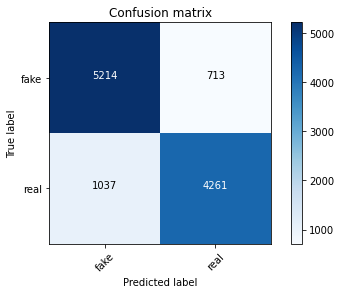

In [198]:
cm = metrics.confusion_matrix(y_test, prediction)
confusion_matrix(cm, classes=['fake', 'real'])

# DATASET 2

In [199]:
# Dataset 2
X_train_2 = pd.read_csv(os.path.join(PATH, "Dataset2/train.csv"))
X_train_2 = shuffle(X_train_2)
X_train_2 = X_train_2.reset_index(drop=True)

In [200]:
X_train_2.head()

,id,title,author,text,label
0,189,UK citizens and war heroes get cheap pre-fab h...,BareNakedIslam,UK citizens and war heroes get cheap pre-fab h...,1
1,7785,Madonna and Hillary: ‘Witch’ and ‘Nasty Woman’...,Caryn Ganz and Patrick Healy,"“I was called a whore and a witch,” Madonna sa...",0
2,9924,Comment on Nomi Prins: Hillary Clinton Will Co...,EndOfTheWorld,by Yves Smith \nYves here. It’s hardly a secre...,1
3,5194,Body Camera Failed to Record Chicago Police Sh...,Mitch Smith,CHICAGO — A Chicago officer whose police po...,0
4,12146,Trump: Intelligence Briefing Shows ‘Absolutely...,Charlie Spiering,Donald Trump asserted that cyber attacks had...,0


In [201]:
# Merge title and text column
X_train_2["text"] =X_train_2["title"] + " " + X_train_2["text"]

# Remove useless columns
X_train_2.drop(["title"],axis=1,inplace=True)
X_train_2.drop(["id"],axis=1,inplace=True)
X_train_2.drop(["author"],axis=1,inplace=True)


In [202]:
Y = X_train_2["label"].values
# Convert train data to gensim format, removing punctuation, stopwords
X = []
stop_words = set(nltk.corpus.stopwords.words("english"))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
for par in X_train_2["text"].values:
    tmp = []
    sentences = nltk.sent_tokenize(str(par))
    for sent in sentences:
        sent = sent.lower()
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
        tmp.extend(filtered_words)
    X.append(tmp)

del X_train_2

In [203]:
#Dimension of vectors generated
EMBEDDING_DIM = 100
w2v_model = gensim.models.Word2Vec(sentences=X, size=EMBEDDING_DIM, window=5, min_count=1)

In [204]:
# Tokenizing Text -> Repsesenting each word by a number
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)
word_index = tokenizer.word_index



In [205]:
# Keep all news at 1000, add padding to news with less than 1000 words and truncating long ones
maxlen = 1000 
X = pad_sequences(X, maxlen=maxlen)

In [206]:
X_train, X_test, y_train, y_test = train_test_split(X, Y) 

In [207]:
X_train


array([[    0,     0,     0, ...,  3959,   158,  2506],
       [ 1272,   564,  2356, ...,  2688,    78,   904],
       [    0,     0,     0, ...,   713,    94,  5579],
       ...,
       [    0,     0,     0, ..., 30211,  6695,   980],
       [    0,     0,     0, ..., 11561,   377,  1432],
       [    0,     0,     0, ...,   363,   392, 29572]], dtype=int32)

In [208]:
model = Pipeline([('model', DecisionTreeClassifier(criterion= 'entropy', max_depth = 40, splitter='best', random_state=42))])
history = model.fit(X_train, y_train)

In [209]:
# Metrics
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
print(classification_report(y_test, prediction))

accuracy: 71.98%
              precision    recall  f1-score   support

           0       0.74      0.68      0.71      2620
           1       0.70      0.76      0.73      2580

    accuracy                           0.72      5200
   macro avg       0.72      0.72      0.72      5200
weighted avg       0.72      0.72      0.72      5200



Confusion matrix, without normalization


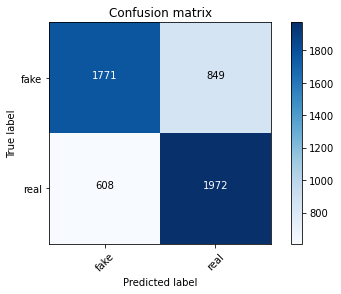

In [210]:
cm = metrics.confusion_matrix(y_test, prediction)
confusion_matrix(cm, classes=['fake', 'real'])